<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None
                         date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633
Duplicated: 0
Empty DataFrame
Columns: [date, sales]
Index: []
count     366.000000
mean      524.963968
std       275.089698
min        53.803211
25%       290.186822
50%       520.699468
75%       763.289263
max      1000.482785
Name: sales, dtype: float64


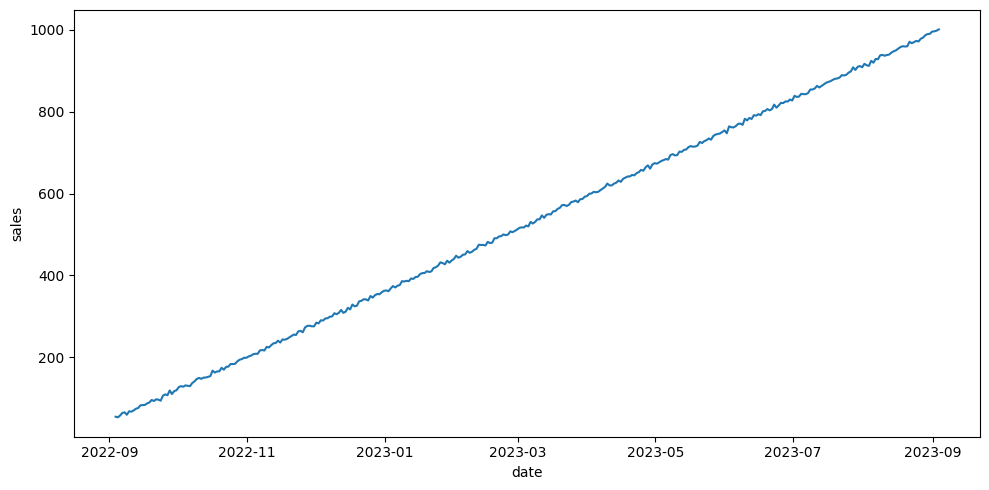

Which is the tensor of the time serie? Day
Which is the trend? Up
Is it stationary? No
Is there variability or noise? Possibly on a smaller timeframe, but it is a clear line when observed over all data
Dickey-Fuller test results:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


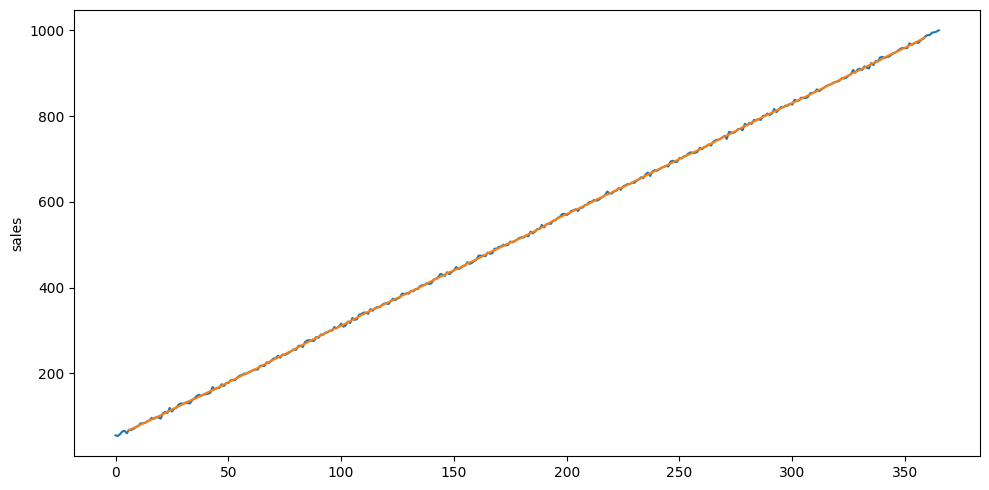

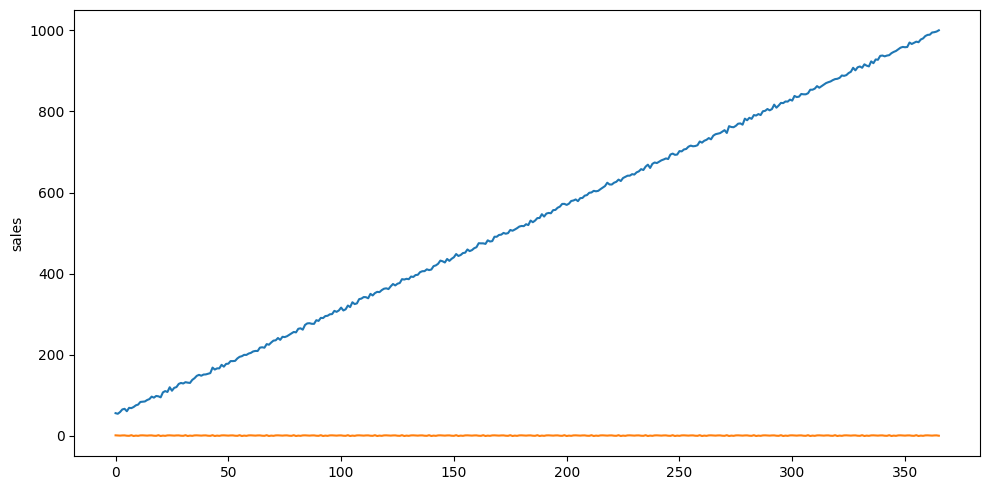

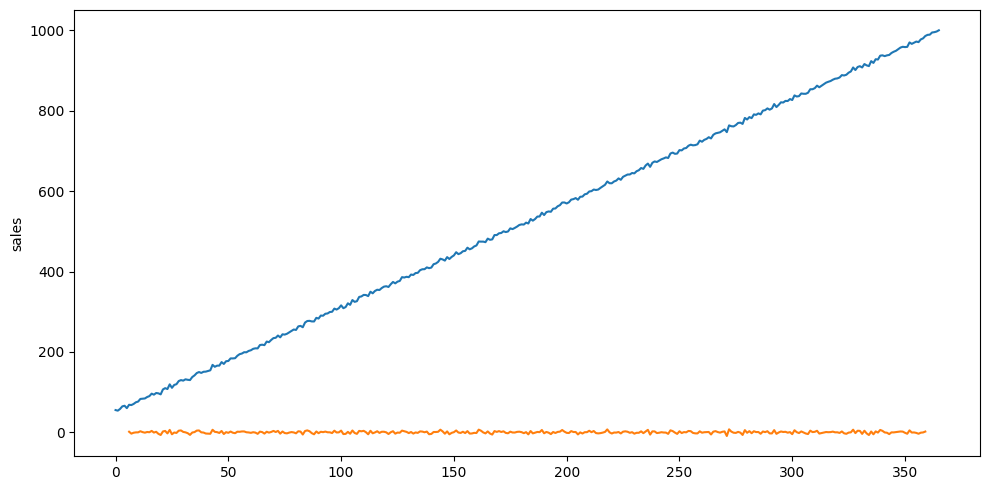

Dickey-Fuller test results:
Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.122, Time=1.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.96 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.048, Time=0.51 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.77 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.18 sec
 ARIMA(2

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exceptio

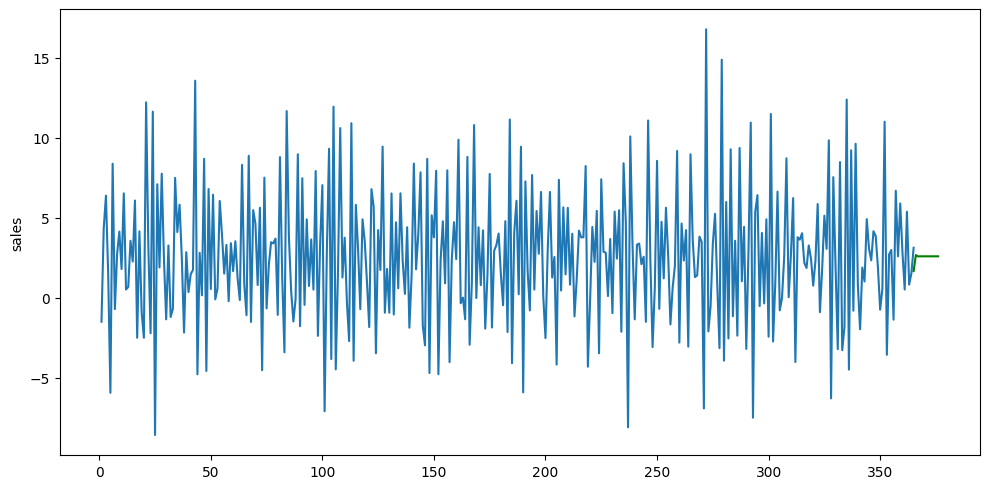

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


# Read data
df = pd.read_csv('/workspaces/machine-learning-python-template-ds-2023/Ryan/raw/sales.csv')

# See info
print(df.info())

# See data
print(df.head())

# Check for duplicates
print(f'''Duplicated: {df.duplicated().sum()}''')
duplicates = df[df.duplicated()]
print(duplicates)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Convert to date format
df["date"] = pd.to_datetime(df["date"])

# ts
ts = df['sales']

# Describe columns
print(df['sales'].describe())


# Plot
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, x='date', y='sales', ax=axis)  # Replace 'sales' with the actual column name for sales values
plt.tight_layout()
plt.show()

print(f'''Which is the tensor of the time serie? Day
Which is the trend? Up
Is it stationary? No
Is there variability or noise? Possibly on a smaller timeframe, but it is a clear line when observed over all data''')

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

print(test_stationarity(ts))

# Decomposition and plot
decomposition = seasonal_decompose(ts, period = 12)
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
sns.lineplot(data = trend)
plt.tight_layout()
plt.show()

# seasonality analysis
seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.show()

# residuals
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

# convert to stationary and check
ts_stationary = ts.diff().dropna()
print(test_stationarity(ts_stationary))

# arima model
model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)
model.summary()

forecast = model.predict(12)
df['prediction'] = model.predict(12)

fig, axis = plt.subplots(figsize = (10,5))
sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = 'green')
plt.tight_layout()
plt.show()

